# Angelo from Experimental phases

Search using experimental tabulated phases in AngeloDatabase Created using Angelo Notebook.

### Imports

In [1]:
from XRDXRFutils import Phase,DatabaseXRD, DataXRF, DataXRD, SpectraXRD, GaussNewton, PhaseList, PhaseMap, PhaseSearch, PhaseMapSave
from XRDXRFutils import GammaMap,ChiMap

import os
import pickle


from joblib import Parallel, delayed
import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import linspace,concatenate,sqrt,log,histogram,array,where
from matplotlib.pyplot import savefig,sca,vlines,show,fill_between,sca,legend,imshow,subplots,plot,xlim,ylim,xlabel,ylabel,cm,title,scatter,colorbar,figure,vlines
from sklearn.cluster import KMeans,MiniBatchKMeans

from multiprocessing import Pool
import gc
from matplotlib import rcParams
from pathlib import Path

from PIL import Image

def f_linear(x,a,b):
    return a*x + b
def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y

#### Define Paths and Spectra Parameters

In [2]:
path_xrd = '/home/shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRD/' # XRD scan
path_xrf = '/home/shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRF/' # XRF scan
path_database = '/home/shared/DatabaseXRD'

path_data = 'data/' # data of intermediate results, for fast loading
path_figures = 'figures/' # figures generated by the script
path_results = 'results/' # results generated by the script: raw data, tif maps

min_theta = 20
max_theta = 53
min_intensity = 0.1 # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)\

sigma = 0.18

## Read XRD Data

from xrd.h5

Loading: /home/shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRD/xrd.h5
a: -1172.8 s: 2053.1 beta: 50.710


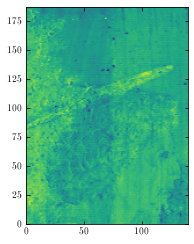

In [3]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5')
except:
    print('Reading from raw data.')
    data = DataXRD().read_params(path_xrd + 'Scanning_Parameters.txt').read(path_xrd).calibrate_from_file(path_xrd + 'calibration.ini').remove_background(std = 5).save_h5(path_xrd + 'xrd.h5')
    
print("a: %.1f s: %.1f beta: %.3f"%(data.opt[0],data.opt[1],data.opt[2]))

figure(figsize=(6,4))
im = imshow(data.data.sum(axis=2))
show()

# Display XRF

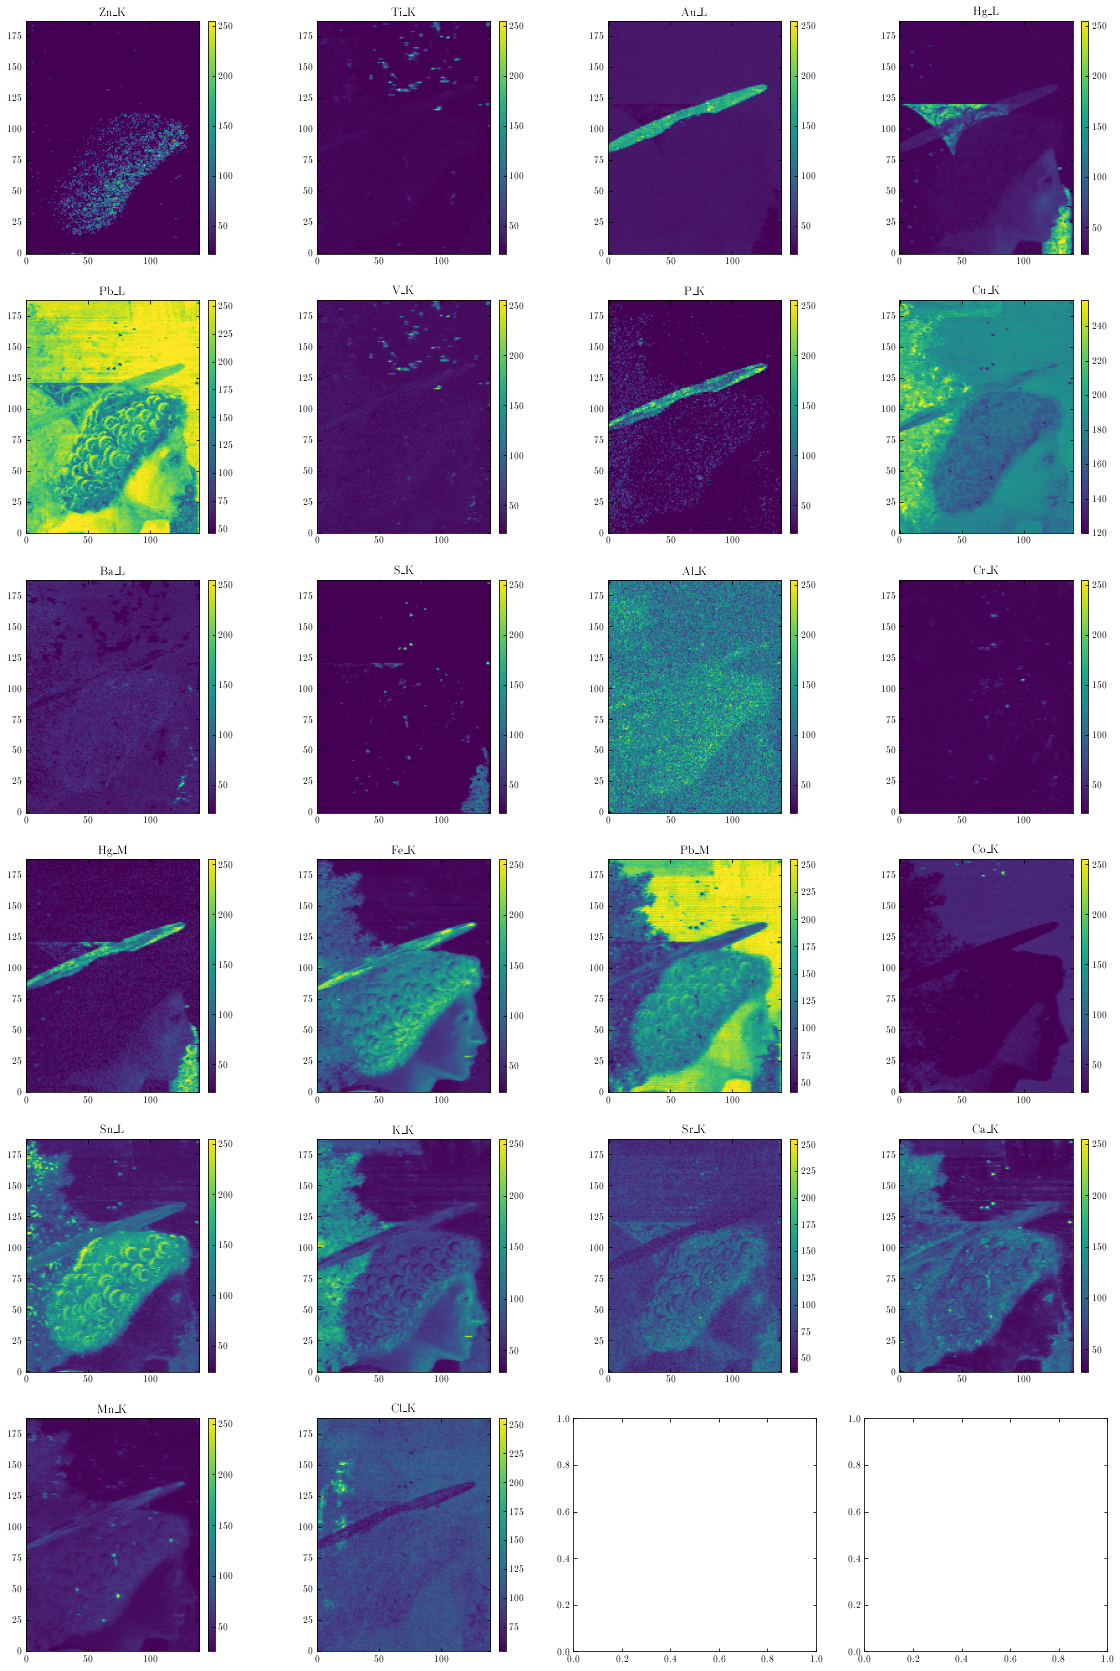

In [4]:
%matplotlib inline

data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = data_xrf.labels[::-1]

n_of_columns = 4

n_of_pictures = len(data_xrf.metadata['labels'])
n_of_rows = n_of_pictures // n_of_columns

if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, ax = subplots(n_of_rows, n_of_columns, figsize = (5 * n_of_columns, 5 * n_of_rows))
for i, label in enumerate(data_xrf.metadata['labels']):
    
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    
    iax = ax[i_row, i_column]
    im = iax.imshow(data_xrf.labels[..., i])
    colorbar(im, ax = iax, cax = iax.inset_axes([1.05, 0, 0.04, 1]))
    
    iax.set_title(label)
    
show()

## Read database
This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [5]:
database = DatabaseXRD().read_cifs(path_database)
databaseExp = DatabaseXRD().read_cifs('AngeloDatabase/')

print('Phases in database:',len(database))
print('Phases in databaseEXP:',len(databaseExp))

lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][1]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]
hematite = database['Hematite'][4]
gold = database['Gold'][0]

huntite = database['Huntite'][0]
as4 = database['As4 O6'][0]

orpiment = database['Orpiment'][0]
cuprorivaite = database['Cuprorivaite'][0]


hydrocerussite = databaseExp['Hydrocerussite'][0]
cinnabar = databaseExp['Cinnabar'][0]

#lazurite = databaseExp['Lazurite'][0]
gold = databaseExp['Gold'][0]

#hematite = databaseExp['Hematite'][0]

gypsum = databaseExp['Gypsum'][0]
pbsn = databaseExp['Pb2 Sn O4'][0]


phases = PhaseList([hydrocerussite, cinnabar, gold, hematite, pbsn,gypsum])

phases.get_theta(min_intensity=min_intensity,
                 min_theta = min_theta,
                 max_theta = max_theta,
                first_n_peaks = first_n_peaks)

if 'p_a' in locals():
    data.opt[0] = p_a
    data.opt[1] = p_s

Phases in database: 137
Phases in databaseEXP: 8


# Search database

In [6]:
elements_chosen = ['K']

for v,k in sorted(database.items()):
    p = k[0]
    if '_chemical_formula_sum' in p:
        if all(e in p['_chemical_formula_sum'] for e in elements_chosen):
            if '_chemical_name_mineral' in p:
                print(p['_chemical_name_mineral'] + ', ', end = '\t')
            print(p['_chemical_formula_sum'] + ', ', end = '\t')
            print(len(k))

Aluminoceladonite, 	Al1.788 H2 K Mg0.64 O12 Si3.572, 	3
Celadonite, 	Al2 H2 K O12 Si4, 	5
Glauconite, 	Al2 H2 K O12 Si4, 	3
Jarosite, 	Fe2.88 H5.83 K0.81 O13.64 S2, 	15


# Plot XRF of selected element

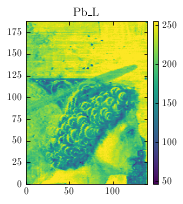

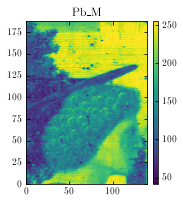

In [7]:
element_chosen = 'Pb'

for i,label in enumerate(data_xrf.metadata['labels']):
    if element_chosen + '_' in label:
        fig, ax  = subplots(figsize=(5,3))
        
        title(label)
        im = imshow(data_xrf.labels[..., i])
        colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))

show()

In [8]:
%%time
pme = ChiMap().from_data(data,phases,sigma = sigma)

CPU times: user 2.5 s, sys: 198 ms, total: 2.69 s
Wall time: 2.69 s


In [9]:
%%time
pme = pme.search()

Using 50 cpu
CPU times: user 26.3 s, sys: 4.52 s, total: 30.8 s
Wall time: 33.9 s


In [10]:
%%time
L1loss, MSEloss, overlap_area = pme.metrics()
rescaling = data.rescaling

Using 50 cpu
CPU times: user 4.12 s, sys: 1.84 s, total: 5.96 s
Wall time: 7.5 s


In [11]:
chi = pme.chi()

In [12]:
chi = where(chi > 1.5,0,chi)

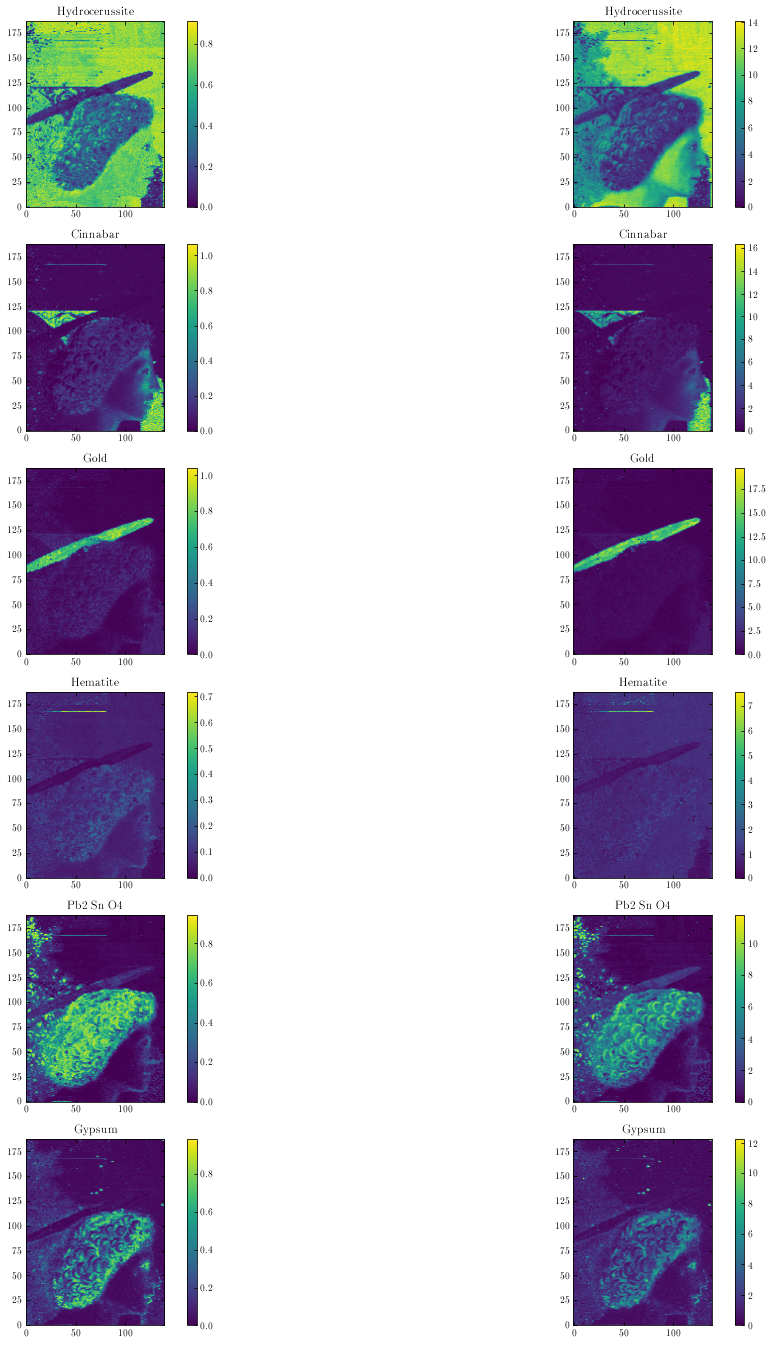

In [13]:
%matplotlib inline

fig,ax = subplots(len(pme.phases),2,figsize=(18,24))

rescaled_chi = chi * rescaling**0.5

for i,phase in enumerate(pme.phases):
    ax[i,0].set_title(phase.label)
    p = ax[i,0].imshow(chi[...,i],vmin=0)
    colorbar(p,ax = ax[i,0])
    
    ax[i,1].set_title(phase.label)
    p = ax[i,1].imshow(rescaled_chi[...,i],vmin=0)
    colorbar(p,ax = ax[i,1])
    
show()

# Save PNG

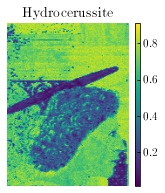

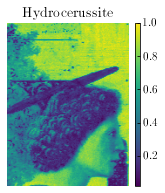

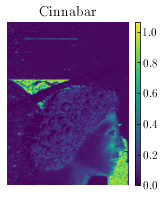

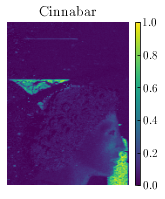

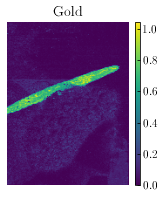

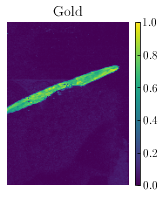

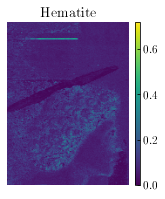

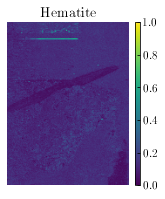

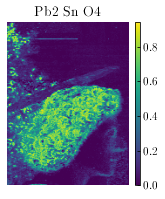

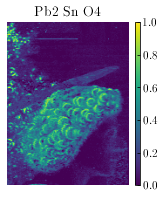

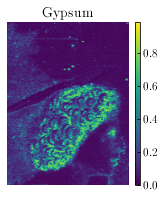

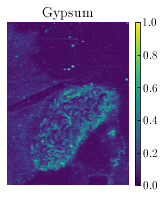

In [14]:
rcParams['font.size'] = 12
Path(path_figures).mkdir(parents=True, exist_ok=True)

for i, phase in enumerate(pme.phases):
    fig, ax  = subplots(figsize=(5,3))

    im = ax.imshow(chi[...,i])
    
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    
    ax.set_title(phase.label)
    ax.axis('off')

    savefig(path_figures + phase.label + '_chi.png', bbox_inches = 'tight', dpi = 300, transparent = False)
    
    fig, ax  = subplots(figsize=(5,3))

    im = ax.imshow(rescaled_chi[...,i]/rescaled_chi[...,i].max())
    
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    
    ax.set_title(phase.label)
    ax.axis('off')

    savefig(path_figures + phase.label + '_rescaled_chi.png', bbox_inches = 'tight', dpi = 300, transparent = False)

show()

# Save TIFF

In [15]:
Path(path_results).mkdir(parents=True, exist_ok=True)

for i, phase in enumerate(pme.phases):
    uint_img = (chi[...,i]/chi[...,i].max() * 255).astype('uint8')[::-1]
    
    img = Image.fromarray(uint_img)   
    img.save(path_results + phase.label + '.tiff')
    
    uint_img = (rescaled_chi[...,i]/rescaled_chi[...,i].max() * 255).astype('uint8')[::-1]
    
    img = Image.fromarray(uint_img)
    img.save(path_results + phase.label + '_rescaled.tiff')

### Histogram of $a$

If $a$ is spead over too large area it might be that the phases are to right or a phase is missing

CPU times: user 97.8 ms, sys: 2.58 ms, total: 100 ms
Wall time: 99.5 ms


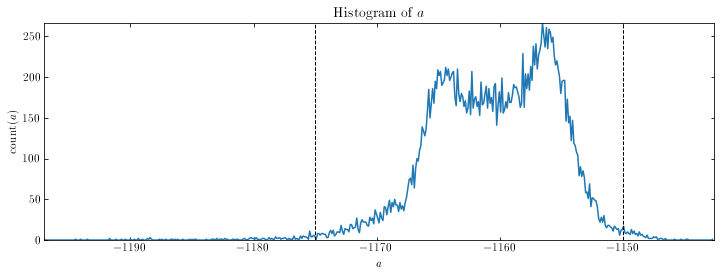

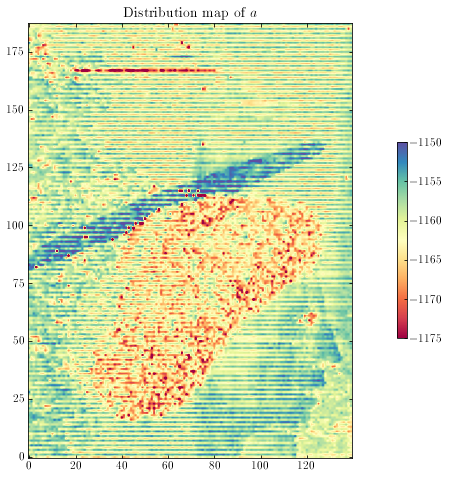

In [16]:
%%time
opt = pme.opt()
a = opt[...,0]
s = opt[...,1]

vmin = -1175
vmax = -1150

h,b = histogram(a,bins=512)

figure(figsize=(12,4))

plot(b[:-1],h)
xlim(b[0],b[-1])
ylim(0,h.max())

vlines(vmin,0,h.max(),'k',ls='--',lw=1)
vlines(vmax,0,h.max(),'k',ls='--',lw=1)

xlabel('$a$')
ylabel(r'count($a$)')
title(r'Histogram of $a$')

figure(figsize=(16,8))
title('Distribution map of $a$')
im = imshow(a,cmap='Spectral',vmin=vmin,vmax=vmax)
colorbar(im,fraction=0.011)

## Plotting the $a,s$ dependence

There is a slight notion of a second $as$ dependence but it is weak.

Linear: [ -1.35085756 469.97739116]
Cauchy: [-7.85420421e-01  1.12625377e+03]
-1160.3924495140295 2037.5022996006007
-1156.55545455527 2034.6360396894113


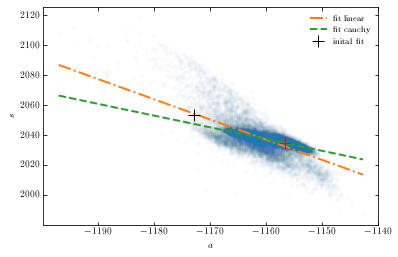

In [17]:
%matplotlib inline

opt,var = curve_fit(f_linear,a.flatten(),s.flatten())
res = least_squares(f_loss,x0=opt,args=(a.flatten(),s.flatten()),loss='cauchy')

linear_y = f_linear(a.flatten(),*opt)
cauchy_y = f_linear(a.flatten(),*res['x'])

print('Linear:',opt)
print('Cauchy:',res['x'])

plot(a.flatten(),s.flatten(),'.',alpha=0.01)

x = linspace(a.min(),a.max(),10)
plot(x,f_linear(x,*opt),'-.',lw=2,label='fit linear')
plot(x,f_linear(x,*res['x']),'--',lw=2,label='fit cauchy')
plot(data.opt[0],data.opt[1],'k+',ms=12,label='inital fit')

print(a.mean(),s.mean())

legend(frameon=False)

xlabel(r'$a$')
ylabel(r'$s$')

pmax_a = b[h.argmax()]
pmax_s = f_linear(pmax_a, *res['x'])

print(pmax_a,pmax_s)

plot(pmax_a,pmax_s,'r+',ms=12,label='most likely')

show()

[-1157.54830464  2039.45047       50.71024216]


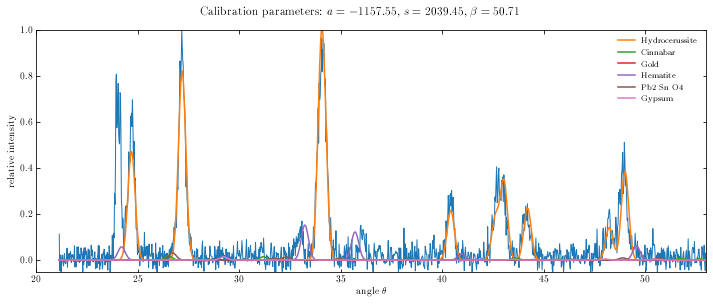

In [18]:
%matplotlib inline
selected = pme.get_pixel(34,187)

fig, ax = subplots(figsize = (12,4))
fig.subplots_adjust(hspace = 0.4, bottom = 0.06, top = 0.9)

print(selected.opt)
fig.suptitle(r'Calibration parameters: $a = %.2f$, $s=%.2f$, $\beta=%.2f$'%(selected.opt[0], selected.opt[1], selected.opt[2]))

profiles = selected.z_decomposed()

selected[0].plot_spectra(lw = 1)

for i in range(len(selected)):
    g = selected[i]
    
    s_chi = selected.chi[0]   
    plot(g.theta,profiles[:,i],label=g.label)

    legend(frameon=False)
    ax.set_ylim(-0.05, 1)
    ax.set_xlim(min_theta, max_theta)
    ax.set_xlabel(r'angle $\theta$')
    ax.set_ylabel(r'relative intensity')
    
show()